In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
cad_df = pd.read_csv('final_data.csv')
cad_df['Cath'].value_counts()

,count
Cath,
0,216
1,87


# ***Recursive Feature Elimination (RFE)***

In [4]:
#Separate features and target columns
X_feature = cad_df.drop('Cath', axis=1)
y_target = cad_df['Cath']

RF_mdl = RandomForestClassifier(random_state=1)
select = RFE(RF_mdl, n_features_to_select=30)  # RFE with 30 features selected
select.fit(X_feature, y_target)
selected_features = X_feature.columns[select.support_]
X_rfe_chosen = X_feature[selected_features]

print("Selected features with RFE:", selected_features.tolist())
print("\nDataframe with only the selected features:")
print(X_rfe_chosen.head(5))

Selected features with RFE: ['Age', 'Weight', 'Length', 'BMI', 'DM', 'HTN', 'BP', 'PR', 'Typical Chest Pain', 'Dyspnea', 'Atypical', 'Nonanginal', 'Tinversion', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR', 'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE', 'Region RWMA', 'VHD']

Dataframe with only the selected features:
   Age  Weight  Length        BMI  DM  HTN   BP   PR  Typical Chest Pain  \
0   53      90     175  29.387755   0    1  110   80                   0   
1   67      70     157  28.398718   0    1  140   80                   1   
2   54      54     164  20.077335   0    0  100  100                   1   
3   66      67     158  26.838648   0    1  100   80                   0   
4   50      87     153  37.165193   0    1  110   80                   0   

   Dyspnea  ...    HB    K   Na    WBC  Lymph  Neut  PLT  EF-TTE  Region RWMA  \
0        0  ...  15.6  4.7  141   5700     39    52  261      50            0   
1        0  ...  13.9  4.7  156   7700     38    

# ***Data splitting***

In [5]:
#60% data for training, 20% data for validation, 20% data for testing
X_train, X_temp, y_train, y_temp = train_test_split(X_rfe_chosen, y_target, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"The training set contains {X_train.shape[0]} patient records and {X_train.shape[1]} features.")
print(f"The validation set contains {X_val.shape[0]} patient records with the same {X_val.shape[1]} features.")
print(f"The test set also holds {X_test.shape[0]} patient records, each with {X_test.shape[1]} features.")

The training set contains 181 patient records and 30 features.
The validation set contains 61 patient records with the same 30 features.
The test set also holds 61 patient records, each with 30 features.


# ***SMOTENC***

In [6]:
categorical_cols = [col for col in X_train.columns if X_train[col].nunique() <= 4]
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=1)
X_balanced, y_balanced = smote_nc.fit_resample(X_train, y_train)

print("Imbalanced distribution:", Counter(y_train))
print("Balanced distribution:", Counter(y_balanced))

Imbalanced distribution: Counter({0: 133, 1: 48})
Balanced distribution: Counter({1: 133, 0: 133})


Applied SMOTENC balancing only to the testing set

In [7]:
X_balanced

,Age,Weight,Length,BMI,DM,HTN,BP,PR,Typical Chest Pain,Dyspnea,...,HB,K,Na,WBC,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD
0,53,108,178,34.086605,0,0,120,80,1,0,...,14.600000,4.200000,139,4700,40,50,129,55,0,1
1,53,80,170,27.681661,0,1,130,75,1,0,...,14.500000,3.700000,141,6800,21,67,227,40,1,3
2,80,51,148,23.283419,0,1,160,70,1,0,...,12.300000,5.100000,149,12400,40,55,260,40,4,3
3,55,91,179,28.401111,0,0,120,80,1,0,...,15.300000,3.800000,142,6800,29,62,214,45,0,3
4,68,60,150,26.666667,1,1,130,80,1,0,...,11.000000,3.900000,150,8600,28,70,190,55,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,55,69,157,28.208440,0,1,128,74,0,1,...,13.373227,3.831693,142,6300,29,62,195,52,0,3
262,49,79,169,27.892674,0,1,126,73,0,1,...,14.147391,3.731594,141,5500,34,60,222,49,0,1
263,51,65,151,28.515596,0,1,98,72,0,1,...,13.524173,3.987583,140,5324,42,51,177,50,0,3
264,40,61,164,22.583435,0,1,112,70,0,1,...,10.865469,3.839592,144,5583,39,52,230,53,0,1


# ***Random Forest Classifier (RF)***

In [8]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']}

RF_mdl = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(RF_mdl, param_random, n_iter=20, cv=5)
RF_randomcv.fit(X_balanced, y_balanced)
RF_param = RF_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(RF_randomcv.best_score_))
print("Optimal parameters of RF classifier: ", RF_param)

#Training RF model with optimal parameters
RF_best_mdl = RandomForestClassifier(**RF_param)
RF_best_mdl.fit(X_balanced, y_balanced)
training_acc = RF_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of RF classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of RF classifier:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4}
Training phase accuracy of RF classifier: 0.9699


*Predicting on the validation and testing data*

In [9]:
val_pred = RF_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = RF_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.76      0.68      0.72        19

    accuracy                           0.84        61
   macro avg       0.81      0.79      0.80        61
weighted avg       0.83      0.84      0.83        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.77      0.85      0.81        20

    accuracy                           0.87        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.87      0.87      0.87        61



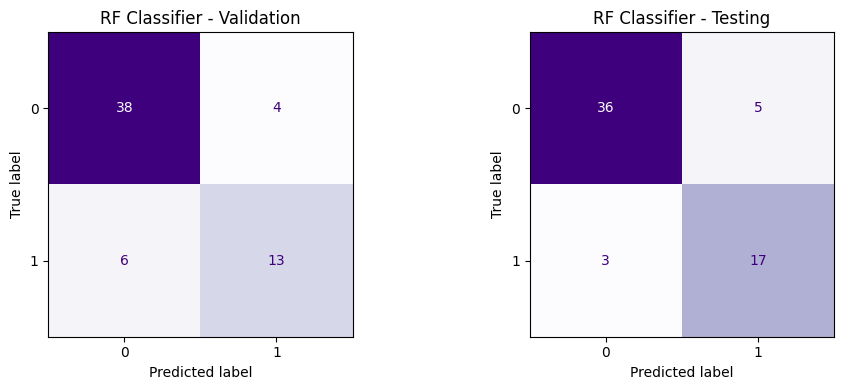

In [10]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('RF Classifier - Validation')

# Plotting the testing confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('RF Classifier - Testing')

plt.tight_layout()
plt.show()

# ***XGBoost (XGB)***

In [11]:
param_random = {'n_estimators': [50, 80, 100],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.01, 0.02, 0.05],
                'subsample': [0.6, 0.7, 0.8]}

XGB_mdl = XGBClassifier()
XGB_randomcv = RandomizedSearchCV(XGB_mdl, param_random, n_iter=20, cv=5)
XGB_randomcv.fit(X_balanced, y_balanced)
XGB_param = XGB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(XGB_randomcv.best_score_))
print("Optimal parameters of XGB classifier: ", XGB_param)

#Training XGB model with optimal parameters
XGB_best_mdl = XGBClassifier(**XGB_param)
XGB_best_mdl.fit(X_balanced, y_balanced)
training_acc = XGB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of XGB classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of XGB classifier:  {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.05}
Training phase accuracy of XGB classifier: 0.9549


*Predicting on the validation and testing data*

In [12]:
val_pred = XGB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = XGB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        42
           1       0.67      0.74      0.70        19

    accuracy                           0.80        61
   macro avg       0.77      0.79      0.78        61
weighted avg       0.81      0.80      0.81        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        41
           1       0.65      0.85      0.74        20

    accuracy                           0.80        61
   macro avg       0.78      0.82      0.79        61
weighted avg       0.83      0.80      0.81        61



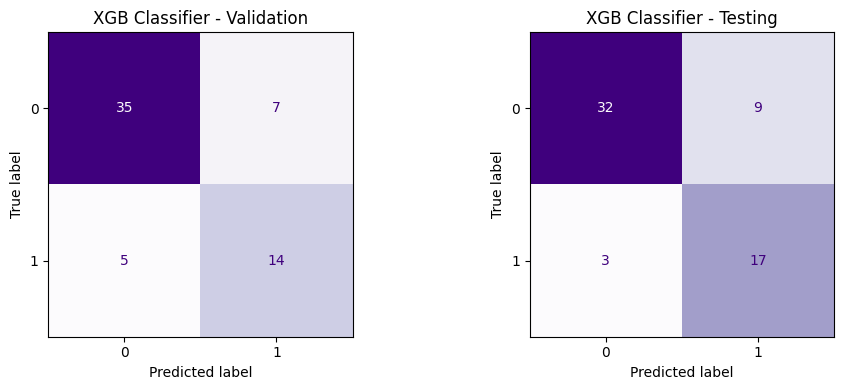

In [13]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('XGB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('XGB Classifier - Testing')

plt.tight_layout()
plt.show()

# ***Gradient Boosting (GB)***

In [14]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.005, 0.001, 0.015],
                'subsample': [0.6, 0.7, 0.8],
                'min_samples_split': [10, 12],
                'min_samples_leaf': [6, 8, 10]}

GB_mdl = GradientBoostingClassifier()
GB_randomcv = RandomizedSearchCV(GB_mdl, param_random, n_iter=20, cv=5)
GB_randomcv.fit(X_balanced, y_balanced)
GB_param = GB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(GB_randomcv.best_score_))
print("Optimal parameters of GB classifier: ", GB_param)

#Training GB model with optimal parameters
GB_best_mdl = GradientBoostingClassifier(**GB_param)
GB_best_mdl.fit(X_balanced, y_balanced)
training_acc = GB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of GB classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of GB classifier:  {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 3, 'learning_rate': 0.015}
Training phase accuracy of GB classifier: 0.9737


*Predicting on the validation and testing data*

In [15]:
val_pred = GB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = GB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        42
           1       0.65      0.79      0.71        19

    accuracy                           0.80        61
   macro avg       0.77      0.80      0.78        61
weighted avg       0.82      0.80      0.81        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        41
           1       0.68      0.85      0.76        20

    accuracy                           0.82        61
   macro avg       0.80      0.83      0.81        61
weighted avg       0.84      0.82      0.82        61



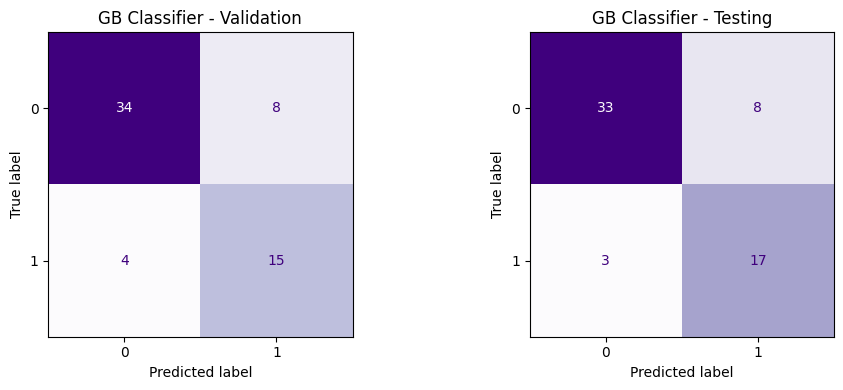

In [16]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('GB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('GB Classifier - Testing')

plt.tight_layout()
plt.show()